In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [25]:



def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    return 2 * concordance_index_censored(e, y, x)[0] - 1


def bootstrap_dxy(df, n=5):
    """ Boostrap and calculate Dxy """
    e, y, x = df.columns
    #print(df.columns)
    result = []

    # resample n times
    for i in range(n):
        sample = df.sample(df.shape[0], replace=True)
        #print(sample)
        # calculate Dxy
        result.append(Dxy(sample[e], sample[y], sample[x]))
    return result

def apply_stats_for_each_value(df, fmap, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (condition_names[value], mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    return result, groups

In [26]:
df = pd.DataFrame({'E': [ 1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0,	1,	1,	1,	1,	1,	1,	1,	]*100, 'Y' : [620, 797, 3218, 1043, 210, 2314, 977, 1003, 609, 1587, 1473, 1216, 2292, 437, 1076, 737, 1516, 372, 1331, 303,]*100})
df['E'] = df['E'].astype(bool)
# generate random risk factor
df['Z']=df['Y']*10

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,2000.0,1.0,1023.0,2.80274,0.66,0.65,0.67


,count,median,min,max,std,mean
agg,,,,,,
Z >=20000,300,2314.0,2292,3218,432.149485,2608.000000
10000 <= Z < 20000,800,1273.5,1003,1587,214.727430,1280.625000
Z < 10000,900,609.0,210,977,237.327590,562.444444


(None, None)

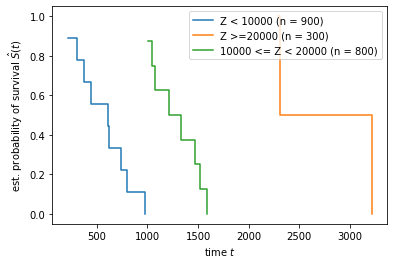

In [27]:
def f_map(x):
    a = int(x['Z'])
    if a < 10000:
        return 2
    if 10000 <= a < 20000:
        return 1
    else:
        return 0

condition_names = {2 : 'Z < 10000', 1: '10000 <= Z < 20000', 0: 'Z >=20000'}

S1, S2 = apply_stats_for_each_value(df, f_map, condition_names)
display(S1), display(S2)